In [18]:
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
# from my_OIB_functions import importOIBgrav,importOIBatm,importOIBrad,mapplotOIBlocal
#from datetime import datetime, date, time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from datetime import datetime, date, time
from pylab import *

def importOIBrad(basedir,timedir,infile):
    datadir = 'IRMCR2'
    # infile = '2009_Antarctica_DC8'
    suffix = '.csv'
    
    ### Read ascii file as csv
    #headers = ('LAT','LONG','DATE','DOY','TIME','FLT','PSX','PSY','WGSHGT','FX','FY','FZ','EOTGRAV','FACOR','INTCOR','FAG070','FAG100','FAG140','FLTENVIRO')
    df = pd.read_csv(os.path.join(basedir, datadir, timedir, infile+suffix),
                     delimiter=",", na_values='-9999.00')
    #df.replace('-9999.00', np.nan)
    
    ### do some DATETIME operations
    #df['DATE'] = str(df['FRAME'][0])[:8]
    
    #df['DATE'] = pd.DataFrame(list(df.FRAMESTR.str[:8]))
    df['FRAMESTR'] = df['FRAME'].apply(str)
    df['DATE'] = pd.to_datetime(list(df.FRAMESTR.str[:8]), format='%Y%m%d')
    # del df['FRAMESTR']
    df['UNIX'] = df['DATE'].astype(np.int64) // 10**9
    df['UNIX'] = df['UNIX']+df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'], unit='s')
    df = df.set_index('iunix')
    return df
            
def importOIBatm(basedir):
    datadir = 'ILATM2'
    infile = '2009_AN_NASA_ATM_all'
    suffix = '.txt'
    
    ### Read ascii file as csv
    headers = ('DATE','TIME','TIME2','LAT','LON','SURFACE_atm','SLOPESN','SLOPEWE','RMS','NUMUSED','NUMOMIT','DISTRIGHT','TRACKID')
    df = pd.read_csv(os.path.join(basedir,infile+suffix),delimiter=r"\s+",header=None)
    df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    del df['TIME2']
    
    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE*1e5)+df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'],format='%Y%m%d')
    df['UNIX']=df['DATE'].astype(np.int64) // 10**9
    df['UNIX']=df['UNIX']+df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'],unit='s')
    df = df.set_index('iunix')
    return df
    
def importOIBgrav(basedir,timedir,infile):
    datadir = 'IGGRV1B'
    #infile = 'IGGRV1B_20091104_13100500_V016'
    #infile = 'IGGRV1B_20091031_11020500_V016'
    #infile = 'IGGRV1B_20091116_15124500_V016'
    
    suffix = '.txt'
    
    ### Read ascii file as csv
    #metadata ends on line 69, column names on line 70
    #headers = ('LAT','LONG','DATE','DOY','TIME','FLT','PSX','PSY','WGSHGT','FX','FY','FZ','EOTGRAV','FACOR','INTCOR','FAG070','FAG100','FAG140','FLTENVIRO')
    print "Reading gravity file: %s" % infile+suffix    
    df = pd.read_csv(os.path.join(basedir, datadir, timedir, infile+suffix),
                     delimiter=r"\s+", skiprows=69)
    headers = df.columns[1:df.shape[1]]
    df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    df.rename(columns={'LONG': 'LON'}, inplace=True)
    #df['ENVIRO'] = df.columns[[19]]
    #df.drop(df.columns['FLTENVIRO'],axis=1,inplace=True)
    
    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE*1e5)+df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'],format='%Y%m%d')
    df['UNIX']=df['DATE'].astype(np.int64) // 10**9
    df['UNIX']=df['UNIX']+df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'],unit='s')
    df = df.set_index('iunix')
    return df
    
def mapplotOIBlocal(x,y,z,title,units,range,colormap):
    #import matplotlib.pyplot as plt
    #########################################
    ### FULL FAG070
    #import matplotlib.cm as cm
    from mpl_toolkits.basemap import Basemap
    fig = plt.figure(figsize=(6.5,8), facecolor='w')
    #create basemap
    m = Basemap(width=600000,height=900000,
                resolution='h',projection='stere',area_thresh = 100000.0,
                lat_ts=-58,lat_0=-67,lon_0=-63.)
    # Draw the coastlines on the map
    m.drawcoastlines()
    # Draw country borders on the map
    m.drawcountries()
    # Fill the land with grey
    #m.fillcontinents(color = 'gainsboro')
    #m.drawmapboundary(fill_color='steelblue')
    #m.bluemarble()
    #m.etopo()
    m.shadedrelief()
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,5.),labels=[1,0,0,0])
    m.drawmeridians(np.arange(-180.,181.,5.),labels=[0,0,0,1])
    # Define our longitude and latitude points
    # We have to use .values because of a wierd bug when passing pandas data
    # to basemap.
    [x1,y1] = m(x.values,y.values)
    # Plot them using round markers of size 6
    m.scatter(x1,y1,c=z,marker="o",cmap=colormap,s=40, edgecolors='none',vmin=range[0],vmax=range[1])#,vmin=-150,vmax=50
    c = plt.colorbar(orientation='vertical', shrink = 0.7)
    c.set_label(units)
    #plt.show()
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.savefig('mapplot_'+title+'.pdf',bbox_inches='tight')   # save the figure to file
    #plt.close(m)
    return

In [20]:
#########################################################
### Read in data sets
# point to data directories
basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
# if os.path.isdir('/Volumes/C/'):
#     basedir = '/Volumes/C/data/Antarctic/OIB/ATM/2009_AN_NASA_ATM'
# else:
#     basedir = '/Volumes/BOOTCAMP/data/Antarctic/OIB/ATM/2009_AN_NASA_ATM'

# Get date of gravity flight TODO make this user specified or for all flights
# infile = 'IGGRV1B_20091104_13100500_V016'
# subframe = 2009110401047

timedir = '2009.10.31'
# subframe = 2009103102018
subframe = 2009103102021

#infile = 'IGGRV1B_20091116_15124500_V016'
#subframe = 2009111601039

In [25]:
#########################################################
### Run functions to read in each data set
infile = 'IGGRV1B_20091031_11020500_V016'
grv = {}
grv = importOIBgrav(basedir,timedir,infile)
grv.head()

infile = 'IRMCR2_20091031_01'
rad = {}
rad = importOIBrad(basedir,timedir, infile)

# infile = 'IGGRV1B_20091031_11020500_V016'
# atm = {}
# atm = importOIBatm(basedir)

Reading gravity file: IGGRV1B_20091031_11020500_V016.txt


In [29]:
# #########################################################
# ###Subsample all to 2 Hz
rad2hz = rad.resample('500L').mean()    #mean,median,mode???
# atm2hz = atm.resample('500L').mean()
rad2hz.rename(columns={'SURFACE': 'SURFACE_radar'}, inplace=True)

In [31]:
# #########################################################
# ### append!
df = {}
df = pd.concat([grv, rad2hz[['THICK','ELEVATION','FRAME','SURFACE_radar','BOTTOM','QUALITY']]], axis=1,join_axes=[grv.index])
# df = pd.concat([grv, rad2hz[['THICK','ELEVATION','FRAME','SURFACE_radar','BOTTOM','QUALITY']], atm2hz[['SURFACE_atm']]], axis=1,join_axes=[df.index])
df['DAY'] = df.index.day
df['HOUR'] = df.index.hour
df['ICEBASE'] = df['ELEVATION']-df['BOTTOM']
df['TOPOGRAPHY'] = df['ELEVATION']-df['SURFACE_radar']
# #df.drop['TIME2']
# ### Some plots
# #df['FAG070'].plot
# #fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(16, 12))
# #df['FAG070'].plot(ax=axes[0],legend=True);#axes[0,0].set_title('A');
# #df['ICEBASE'].plot(ax=axes[1],legend=True);#axes[0,0].set_title('A');

In [32]:
print(df['FRAME'].head())

iunix
2009-10-31 11:02:05   NaN
2009-10-31 11:02:05   NaN
2009-10-31 11:02:06   NaN
2009-10-31 11:02:06   NaN
2009-10-31 11:02:07   NaN
Name: FRAME, dtype: float64


In [8]:
#########################################################
### subset one glacier profile by hand
#dfsub = df['2009-10-31 15:25:00':'2009-10-31 15:50:00']
#
# Larsen C
#dfsub = df['2009-11-04 23:00:00':'2009-11-04 23:15:00']
#dfsub = df.loc[df['FRAME'] == 2009110401046]
#dfsub = df.loc[df['FRAME'].isin(['2009110401047','2009110401048'])]
#
# THE ONE BELOW WORKS
df_sub = df.query('(FRAME <= @subframe+2) & (FRAME >= @subframe-2)')
print(df_sub.head())

Empty DataFrame
Columns: [LAT, LON, DATE, DOY, TIME, FLT, PSX, PSY, WGSHGT, FX, FY, FZ, EOTGRAV, FACOR, INTCOR, FAG070, FAG100, FAG140, FLTENVIRO, FLTENVIRO, DATETIME, UNIX, THICK, ELEVATION, FRAME, SURFACE_radar, BOTTOM, QUALITY, DAY, HOUR, ICEBASE, TOPOGRAPHY]
Index: []

[0 rows x 32 columns]


In [9]:
### using FX moving average
# window = 240 for plane maneuvers > 2 minutes
df['FX_MA'] = df['FX'].rolling(window=240, center=True).mean()
df_2 = df.query('(WGSHGT < 3000) & (FX_MA < 70000)')

### plots

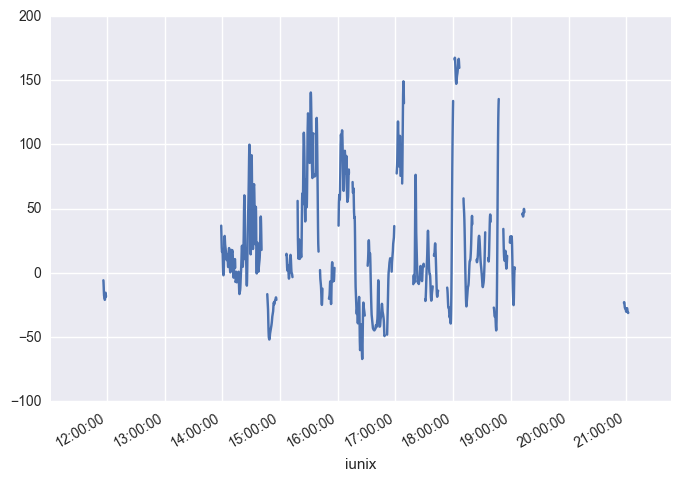

In [10]:
plt.figure(facecolor='w')
df['FAG070'].where((df['WGSHGT'] < 3000) & (df['FX_MA'] < 100000)).plot()

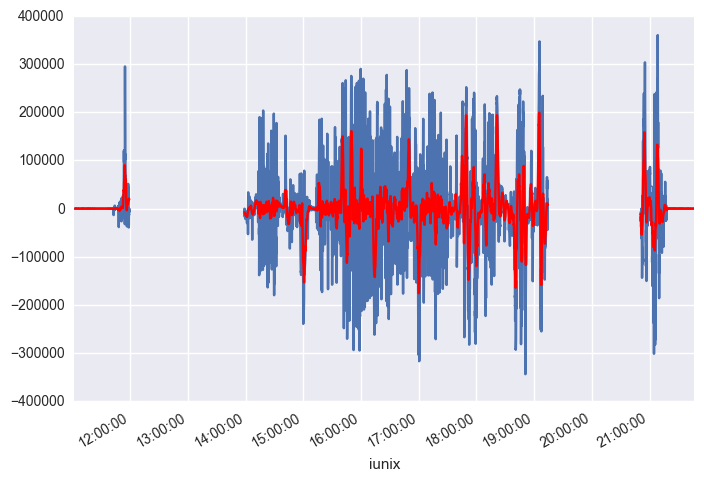

In [11]:
# overplot
plt.figure(facecolor='w')
df['FX'].where((df['WGSHGT'] < 3000)).plot()
df['FX_MA'].where((df['WGSHGT'] < 3000)).plot(color='red')

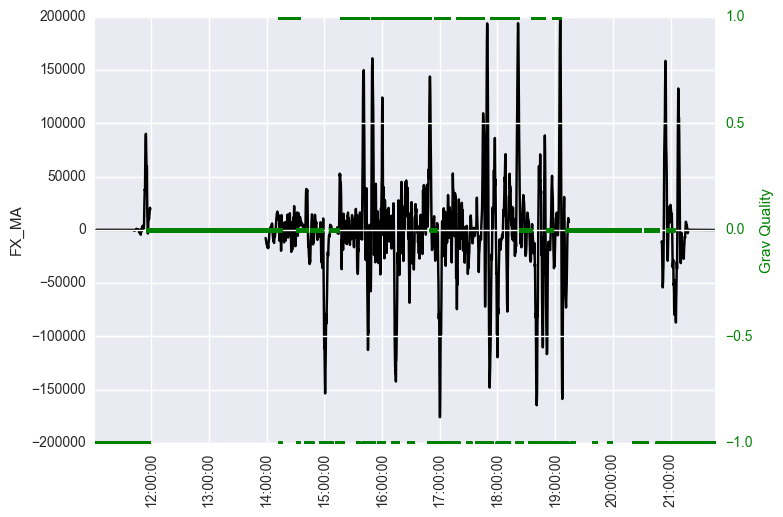

In [13]:
# setup a common plotting space
fig = plt.figure(facecolor='white')
plt.grid(b='on')
plt.xticks(rotation=90)

# ax1 is first
ax1 = fig.add_subplot(111)
ax1.plot(df['FX_MA'].where(df['WGSHGT'] < 3000), color='black')
ax1.set_ylabel('FX_MA')

# second plot is ax2
ax2 = ax1.twinx()
ax2.plot(df['FLTENVIRO'], '.g')
ax2.set_ylabel('Grav Quality', color='g')
# this is to change tick marks to green
for tl in ax2.get_yticklabels():
    tl.set_color('g')
    
# save figure to "figs" directory
# plt.savefig('figs/timeseries_WTMPvsDO_2014.png')

In [15]:
# overplot
plt.figure(facecolor='w')
plt.plot(df['FX_MA'].where((df['FLTENVIRO'] == -1)), color='red')
plt.plot(df['FX_MA'].where((df['FLTENVIRO'] == 0)), color='yellow')
plt.plot(df['FX_MA'].where((df['FLTENVIRO'] == 1)), color='green')
plt.title('FX-MA')
plt.xlabel("Hour")
plt.ylabel(" ")
plt.grid(b='on')
plt.xticks(rotation=90)
plt.legend(('-1', '0', '1'), loc='lower right')

ValueError: cannot reindex from a duplicate axis

In [ ]:
#########################################################
### LINE plots
#plt.figure(); dfsub.plot(subplots=True,layout=(4,8),figsize=(16, 12));
# more control
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), facecolor='w')
df_sub['FAG070'].plot(ax=axes[0],legend=True,style ='b-');#axes[0,0].set_title('A');
df_sub['FAG140'].plot(ax=axes[0],legend=True,style ='r-');#axes[0,0].set_title('A');
df_sub['ELEVATION'].plot(ax=axes[1],legend=True,style ='g');#axes[0,0].set_title('A');
df_sub['ICEBASE'].plot(ax=axes[1],legend=True,style ='k');#axes[0,0].set_title('A');
df_sub['TOPOGRAPHY'].plot(ax=axes[1],legend=True,style ='b');#axes[0,0].set_title('A');
plt.suptitle(str(subframe), y=1.02)
# plt.savefig('profile_'+str(subframe)+'.pdf',bbox_inches='tight')   # save the figure to file

In [ ]:
print(df.columns[18:20])
print(df[:][18:20])

### mapplot

In [ ]:
mapplotOIBlocal(df['LON'], df['LAT'], df['FAG070'].where((df['WGSHGT'] < 3000)), 'FAG070 (below 3000)','mGal',[-50,150],cm.RdBu)

In [ ]:
mapplotOIBlocal(df['LON'], df['LAT'], df['FX_MA'].where((df['WGSHGT'] < 3000)), 'FX_MA','mGal',[-100000,100000],cm.RdBu)

In [ ]:
plt.figure(facecolor='w')
mapplotOIBlocal(df_sub['LON'], df_sub['LAT'], df_sub['FAG070'], 'FAG070 (below 3000, small FX)','mGal',[-50,150],cm.RdBu)